## Fill the Missing Age (Age Group) Values Based on Reader Taste (for illustration purposes only)

We estimate missing age groups by comparing users’ reading behavior.
Using cosine similarity on a binary user-book interaction matrix, we identify the 5 most similar users (based on shared reading habits) for each user with unknown age. The predicted age group is assigned by majority vote among these nearest neighbors. In case of a tie, the result is chosen at random from the top-voted groups.

This approach assumes that readers with similar book preferences tend to belong to similar demographic segments.

⸻

**Note**: A full-scale implementation would require careful optimization, handling technical issues (e.g. sparse vectors representation), and proper evaluation. The purpose here is to illustrate the idea, not to produce a production-ready model.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
books = pd.read_csv('../data/Books.csv', low_memory=False) # Solved Warning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
users = pd.read_csv('../data/Users.csv')
ratings = pd.read_csv('../data/Ratings.csv')

Missing age entries: 110762 (39.72%)
Non-missing age entries: 168096 (60.28%)


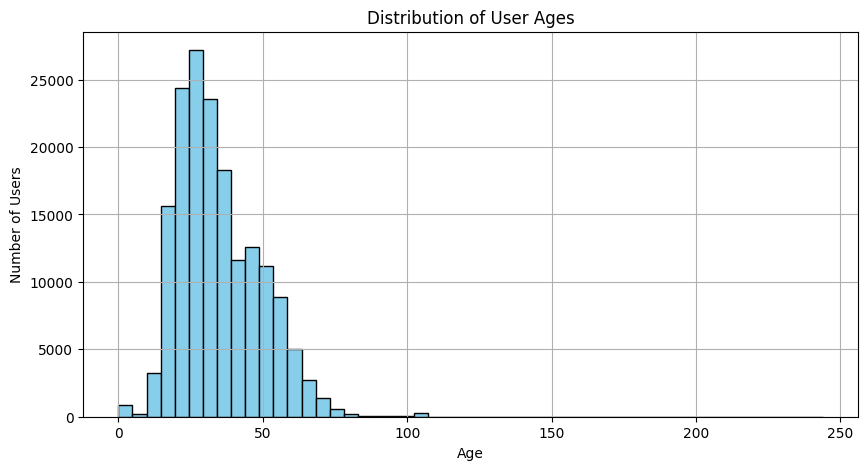

In [2]:
# Identify missing age entries
total_users = len(users)
missing_age_count = users['Age'].isna().sum()
non_missing_age_count = users['Age'].notna().sum()

missing_pct = missing_age_count / total_users * 100
non_missing_pct = non_missing_age_count / total_users * 100

print(f"Missing age entries: {missing_age_count} ({missing_pct:.2f}%)")
print(f"Non-missing age entries: {non_missing_age_count} ({non_missing_pct:.2f}%)")


# Step 2: Histogram of non-missing, reasonable age values
valid_ages = users['Age'].dropna()
plt.figure(figsize=(10, 5))
plt.hist(valid_ages, bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of User Ages')
plt.xlabel('Age')
plt.ylabel('Number of Users')
plt.grid(True)
plt.show()


In [3]:
# Replace invalid ages with NaN
users['Clean_Age'] = users['Age'].apply(lambda x: x if 6 <= x <= 99 else np.nan)

# Define improved age group assignment function
def assign_age_group(age):
    if pd.isna(age):
        return 'unknown'
    elif 6 <= age <= 12:
        return 'child'
    elif 13 <= age <= 17:
        return 'teen'
    elif 18 <= age <= 24:
        return 'young adult'
    elif 25 <= age <= 39:
        return 'adult'
    elif 40 <= age <= 59:
        return 'middle-aged'
    else:  # 60–99
        return 'senior'

# Apply age group categorization
users['Age_Group'] = users['Clean_Age'].apply(assign_age_group)

# Show distribution
print(users['Age_Group'].value_counts(dropna=False))

Age_Group
unknown        112043
adult           69077
middle-aged     45511
young adult     32004
teen            10844
senior           8821
child             558
Name: count, dtype: int64


In [4]:
# Count ratings per user
user_rating_counts = ratings['User-ID'].value_counts()

# Keep only users with at least 5 ratings 
active_users = user_rating_counts[user_rating_counts >= 5].index
filtered_ratings = ratings[ratings['User-ID'].isin(active_users)]

# Merge ratings with users and books
merged = filtered_ratings.merge(users, on='User-ID', how='left')
merged = merged.merge(books, on='ISBN', how='left')

# Get unique users from the merged data
filtered_users = merged[['User-ID', 'Age_Group']].drop_duplicates()

# Show updated Age_Group distribution
print(filtered_users['Age_Group'].value_counts(dropna=False))

Age_Group
adult          7529
unknown        7254
middle-aged    4409
young adult    2179
senior          796
teen            567
child            82
Name: count, dtype: int64


In [5]:
# Add a 'Read' column with value 1 (every rating means the book was read)
merged['Read'] = 1

# Count how many users read each book
book_read_counts = merged['ISBN'].value_counts()

# Keep only books read by at least 10 users
popular_books = book_read_counts[book_read_counts >= 10].index
filtered_merged = merged[merged['ISBN'].isin(popular_books)]

# Create pivot table: users as rows, books as columns, binary values
user_book_matrix = filtered_merged.pivot_table(
    index='User-ID',
    columns='ISBN',
    values='Read',
    fill_value=0
)


In [6]:
# Get User-IDs with unknown age
unknown_age_users = users[users['Age_Group'] == 'unknown']['User-ID'].unique()

# Drop these users from the user-book matrix
user_book_matrix = user_book_matrix.drop(index=unknown_age_users, errors='ignore')

# check new shape
print(f"User-book matrix shape after dropping unknown-age users: {user_book_matrix.shape}")

User-book matrix shape after dropping unknown-age users: (14285, 16397)


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import random

# Create binary user-book matrix (including unknown-age users)
user_book_matrix = filtered_merged.pivot_table(
    index='User-ID',
    columns='ISBN',
    values='Read',
    fill_value=0
)

# Identify known and unknown users
user_age_map = users.set_index('User-ID')['Age_Group']
known_users = user_age_map[user_age_map != 'unknown'].index.intersection(user_book_matrix.index)
unknown_users = user_age_map[user_age_map == 'unknown'].index.intersection(user_book_matrix.index)

# Prepare known and unknown matrices
known_matrix = user_book_matrix.loc[known_users]
unknown_matrix = user_book_matrix.loc[unknown_users]

# Build lookup for known user age groups
age_group_lookup = user_age_map.to_dict()

# Predict age group for each unknown user
predicted_age_groups = {}

for uid in unknown_matrix[1:6].index: #Just as an example result fot first 5 unkown users
    target_vector = unknown_matrix.loc[[uid]].values  # Keep 2D shape
    similarities = cosine_similarity(target_vector, known_matrix.values)[0]
    
    # Get top 5 most similar users
    top_indices = similarities.argsort()[::-1][:5]
    top_user_ids = known_matrix.index[top_indices]
    
    # Get their age groups
    top_age_groups = [age_group_lookup[uid_] for uid_ in top_user_ids]
    
    # Find majority vote (resolve tie randomly)
    counts = pd.Series(top_age_groups).value_counts()
    top_group = counts[counts == counts.max()].index.tolist()
    predicted_age = random.choice(top_group)
    print(counts)
    print(top_group)
    print(predicted_age)
    predicted_age_groups[uid] = predicted_age

# Create DataFrame with predictions
predicted_df = pd.DataFrame.from_dict(predicted_age_groups, orient='index', columns=['Predicted_Age_Group'])
predicted_df.index.name = 'User-ID'
predicted_df = predicted_df.reset_index()

print(predicted_df.head(10))